In [43]:
%reset -f
%reload_ext autoreload
%autoreload 2
%matplotlib inline
# %matplotlib widget

import os, sys, pickle, subprocess
import skbeam


here = os.getcwd()

In [44]:
from os.path import join
here

'/home/mt/Dropbox/code/kitchen/topas-automation'

In [34]:
sys.path.append('../../xrd-analysis')
from functions import *

In [35]:
def write_xy(smpl,ind,wl,tiff_bg,bgscale,save_to=os.getcwd()):
    
    from skbeam.core.utils import q_to_twotheta
    tiff_bg.q_interp(qin=smpl.tiffs[ind].Q)
    
    Q, I = smpl.tiffs[ind].Q, smpl.tiffs[ind].I-bgscale*tiff_bg.Ii
    TTH = np.rad2deg(q_to_twotheta(Q,wl))
    
    out = np.column_stack( (TTH,I ) )
    np.savetxt(os.path.join(save_to,smpl.tiffs[ind].filename.split('/')[-1]+'.xy'), out, delimiter=' ')
    
    return [TTH,I]

def write_inp(smpl,ind,wl,save_to=os.getcwd()):
    
    xyfile = smpl.tiffs[ind].filename.split('/')[-1]+'.xy'

    f=open(os.path.join(save_to,smpl.tiffs[ind].filename.split('/')[-1]+'.inp'),"w+")  
    f.write("""
r_exp  23.169676 r_exp_dash  45.8793749 r_wp  11.301856 r_wp_dash  22.3793414 r_p  8.52307273 r_p_dash  23.4616632 weighted_Durbin_Watson  0.360683884 gof  0.487786537
iters 100000
do_errors
xdd "%(xyfile)s"
    r_exp  23.169676 r_exp_dash  45.8793749 r_wp  11.301856 r_wp_dash  22.3793414 r_p  8.52307273 r_p_dash  23.4616632 weighted_Durbin_Watson  0.360683884 gof  0.487786537
    x_calculation_step 0.002
    range 1
    bkg @  11.7056269`_0.0495132686  2.99137558`_0.0798722926 -1.75073253`_0.07532075  0.740034659`_0.0732614746  0.27492922`_0.0700315145 -0.378864895`_0.0679030194  0.113033711`_0.0660782348  0.0815393622`_0.0667017504  0.505631902`_0.062303958  1.122974`_0.0634920618
    start_X  2.5
    finish_X  15
    LP_Factor( 90)
    Rp 217.5
    Rs 217.5
    lam
        ymin_on_ymax  0.001
        la  1 lo  %(wl).5f lh  0.1
    hkl_Is 
        lebail  1
        hkl_m_d_th2 1 1 1 8  2.054194     5.11767      I  4.42477
        hkl_m_d_th2 2 0 0 6  1.778984     5.91003      I  2.31580
        hkl_m_d_th2 2 2 0 12  1.257932     8.36176      I  5.61486
        hkl_m_d_th2 3 1 1 24  1.072768     9.80831      I  12.62934
        hkl_m_d_th2 2 2 2 8  1.027097     10.24558     I  6.82321
        hkl_m_d_th2 4 0 0 6  0.889492     11.83586     I  1.23060
        hkl_m_d_th2 3 3 1 24  0.816254     12.90215     I  19.03299
        hkl_m_d_th2 4 2 0 24  0.795586     13.23881     I  7.34270
        hkl_m_d_th2 4 2 2 24  0.726267     14.50888     I  9.05854
        LVol_FWHM_CS_G_L( 1, 24.32394`_0.33591, 0.89, 34.00508`_0.46960,,,@, 38.20796`_0.52764)
        TCHZ_Peak_Type(, 0.043745,, 0.002665796,, 0.0004827216,, 0,, 0.01274415,, 0.002455547)
        r_bragg  1.05293318
        phase_MAC  0
        phase_name "Fm3m"
        space_group "Fm-3m"
        scale @  0.0080581142`_4.611e-005
        MVW( 0.000, 45.041`_0.002, 0.000`_0.000)
        Cubic(@  3.557968`_0.000058)
  
""" % vars())
    f.close()    

    
from subprocess import call
def run_topas(start_dir,filename,topas_dir='C:\\TOPAS6\\'):
    os.chdir(topas_dir)
    call('./TC' + ' ' + '"'+ start_dir + '\\' + filename + '"') 
    os.chdir(start_dir)
    
    
def plot_outs(outs):    
    fig = plt.figure(figsize=(8,4))
    ax = fig.add_subplot('111')
    for i in outs:
        ax.plot(i[0],i[1])
    ax.set_yscale('log')
    ax.set_ylim(bottom=1)
    ax.set_xlim([0,15])    
    plt.tight_layout()
    ax.set_xlabel(u'Two theta ($^{o}$)', fontsize=14, weight='bold')
    ax.set_ylabel(u'Intensity', fontsize=14, weight='bold')
    
    
def get_xy_and_lattice(filename):
    xy = np.loadtxt(filename+'.xy',unpack=True)
    f = open(filename+'.out','r')
    for line in f:
        if line.startswith('        Cubic'):
            return [xy,float(line.split()[1][0:6])]
        

def plot_xy_and_lattice(xys,cs,startfrom=0,stopfrom=None):
    fig = plt.figure(figsize=(8,4))
    ax = fig.add_subplot('121')

    for i in xys[startfrom:stopfrom]:
        ax.plot(i[0],i[1])
    ax.set_yscale('log')
    ax.set_ylim(bottom=1)
    ax.set_xlim([2.5,15])    
    ax.set_xlabel(u'Two theta ($^{o}$)', fontsize=14, weight='bold')
    ax.set_ylabel(u'Intensity', fontsize=14, weight='bold') 

    ax = fig.add_subplot('122')

    ax.plot(cs[startfrom:stopfrom],'-o',ms=2)
    ax.set_xlabel(u'Scan index', fontsize=14, weight='bold')
    ax.set_ylabel(u'Fm3m lattice constant', fontsize=14, weight='bold') 

    plt.tight_layout()
    

In [36]:
# load background, LaB6, and P0-AR
bckg = SAMPLE()
bckg.load(load_from='background.pklz',meta_id=-1)
# bckg.plot(figsize=(6,4),q_range=(-1,11),y_bottom=5)

lab6 = SAMPLE()
lab6.load(load_from='LaB6.pklz',meta_id=-1)
# lab6.plot(figsize=(6,4),q_range=(-1,11),y_bottom=5)

In [37]:
here = os.getcwd()

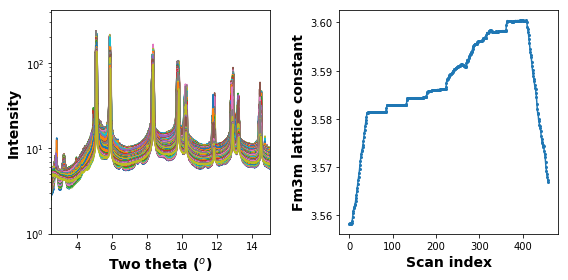

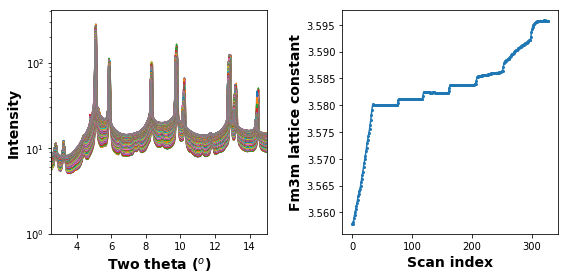

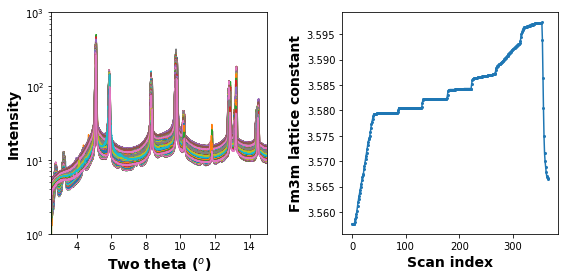

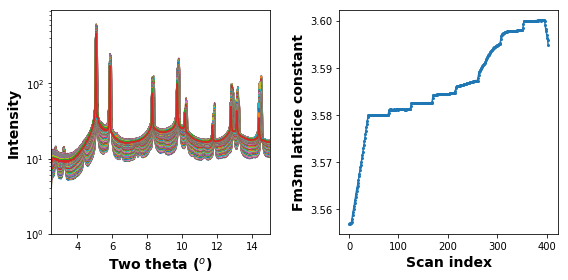

In [38]:
big_picture = []

c = 0
startfroms = [23,15,15,11]
stopfroms = [-40,None,None,None]
for s in ['FC-4','FC-5','FC-6','FC-7']:
    datapath = join(here,'data','2016Oct')
    smpl = SAMPLE()
    smpl.load(load_from=join(datapath,s+'.pklz'),meta_id=-1)
    # smpl.plot(figsize=(8,4),q_range=(0,10),y_bottom=10)
    wl = 0.18342 # wl = smpl.tiffs[ind].meta_yaml['calibration_md']['wavelength']*10000000000

    xys = [] 
    cs = []
    for i,t in enumerate(smpl.tiffs):
    #     write_xy(smpl,ind=i,wl=wl,tiff_bg=bckg.tiffs[0],bgscale=0.8,
    #                          save_to=join(here,s,'automated'))
    #     write_inp(smpl,ind=i,wl=wl,save_to=join(here,s,'automated'))
    #     run_topas(join(here,s,'automated'),t.filename.split('/')[-1]+'.inp') 
        out = get_xy_and_lattice(join(here,s,'automated',t.filename.split('/')[-1]))
        xys.append(out[0])
        cs.append(out[1])
        
    big_picture.append([s,cs[startfroms[c]:stopfroms[c]]])
    plot_xy_and_lattice(xys,cs,startfrom=startfroms[c],stopfrom=stopfroms[c])

    c += 1

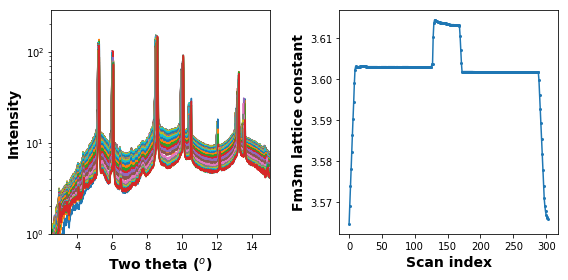

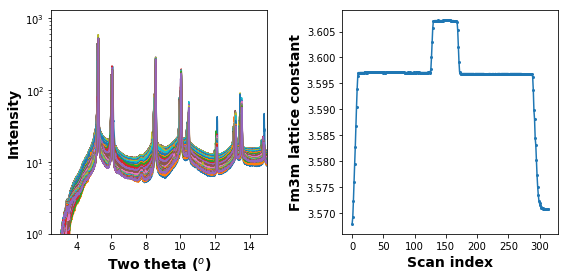

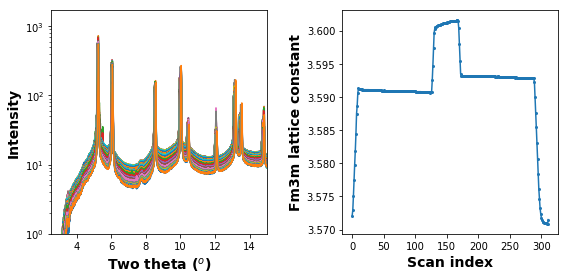

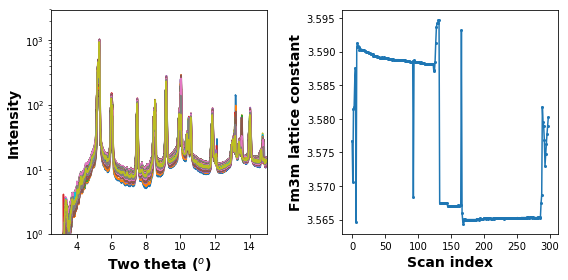

In [39]:
c = 0
startfroms = [0,0,0,0]
stopfroms = [None,None,-88,-10]
for s in ['P0-AR','P1-AR','P2-AR','P3-AR']:
    datapath = join(here,'data','2018July') 
    smpl = SAMPLE()
    smpl.load(load_from=join(datapath,s+'.pklz'),meta_id=-1)
    # smpl.plot(figsize=(8,4),q_range=(0,10),y_bottom=10)
    # wl = smpl.tiffs[ind].meta_yaml['calibration_md']['wavelength']*10000000000

    xys = [] 
    cs = []
    for i,t in enumerate(smpl.tiffs):
    #     write_xy(smpl,ind=i,wl=wl,tiff_bg=bckg.tiffs[0],bgscale=0.8,
    #                          save_to=join(here,s,'automated'))
    #     write_inp(smpl,ind=i,wl=wl,save_to=join(here,s,'automated'))
    #     run_topas(join(here,s,'automated'),t.filename.split('/')[-1]+'.inp') 
        out = get_xy_and_lattice(join(here,s,'automated',t.filename.split('/')[-1]))
        if out[1] < 3.62:
            xys.append(out[0])
            cs.append(out[1])
        else:
            xys.append(xys[-1])
            cs.append(cs[-1])            
            
    big_picture.append([s,cs[startfroms[c]:stopfroms[c]]])
    plot_xy_and_lattice(xys,cs,startfrom=startfroms[c],stopfrom=stopfroms[c])
    c += 1

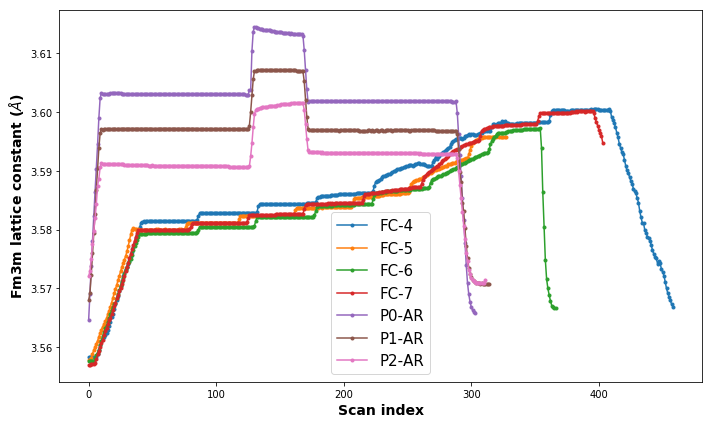

In [40]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot('111')

for i in big_picture[0:-1]:
    ax.plot(i[1],'-o',ms=3,label=i[0])
ax.legend(fontsize=15)

ax.set_xlabel(u'Scan index', fontsize=14, weight='bold')
ax.set_ylabel(u'Fm3m lattice constant ($\AA$)', fontsize=14, weight='bold') 

plt.tight_layout()

plt.savefig('big_picture.pdf')

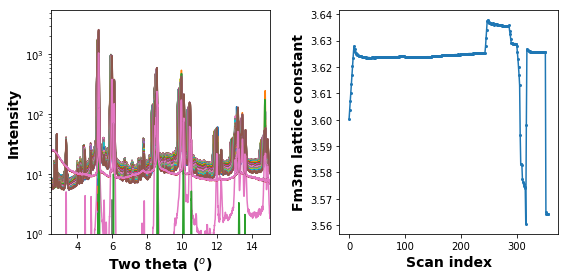

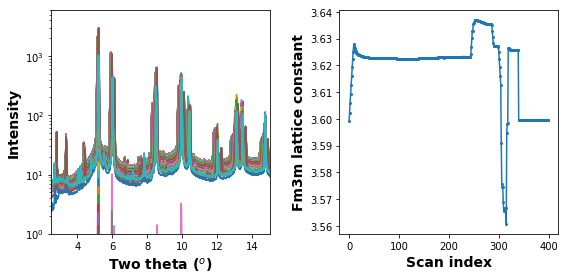

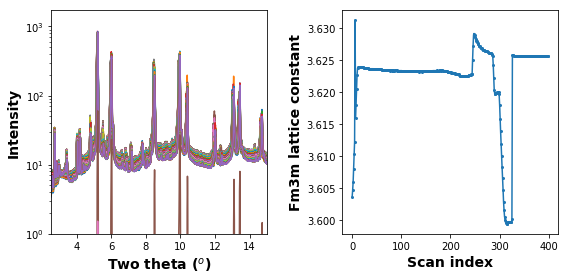

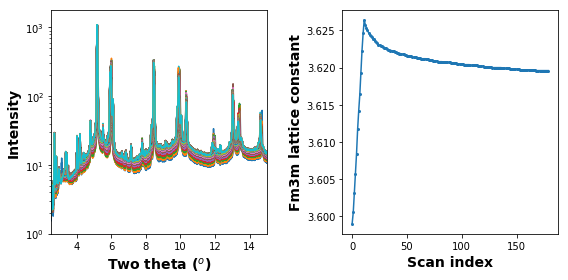

In [41]:
c = 0
startfroms = [0,0,0,0]
stopfroms = [None,None,None,None]
for s in ['Ni2v-480','Ni2v-500','Ni2v-520','Ni2v-540']:
    datapath = join(here,'data','2018July') 
    smpl = SAMPLE()
    smpl.load(load_from=join(datapath,s+'.pklz'),meta_id=-1)
#     smpl.plot(figsize=(8,4),q_range=(0,10),y_bottom=10)
    wl = smpl.tiffs[0].meta_yaml['calibration_md']['wavelength']*10000000000

    xys = [] 
    cs = []
    outs = []
    for i,t in enumerate(smpl.tiffs):
#         out = write_xy(smpl,ind=i,wl=wl,tiff_bg=bckg.tiffs[0],bgscale=0.4,
#                              save_to=join(here,s,'automated'))
#         outs.append(out)
#         write_inp(smpl,ind=i,wl=wl,save_to=join(here,s,'automated'))
#         run_topas(join(here,s,'automated'),t.filename.split('/')[-1]+'.inp') 
#         print(t.filename)
        out = get_xy_and_lattice(join(here,s,'automated',t.filename.split('/')[-1]))
        if out[1] < 4:
            xys.append(out[0])
            cs.append(out[1])
        else:
            xys.append(xys[-1])
            cs.append(cs[-1])  

#     plot_outs(outs)
            
    big_picture.append([s,cs[startfroms[c]:stopfroms[c]]])
    plot_xy_and_lattice(xys,cs,startfrom=startfroms[c],stopfrom=stopfroms[c])
    c += 1

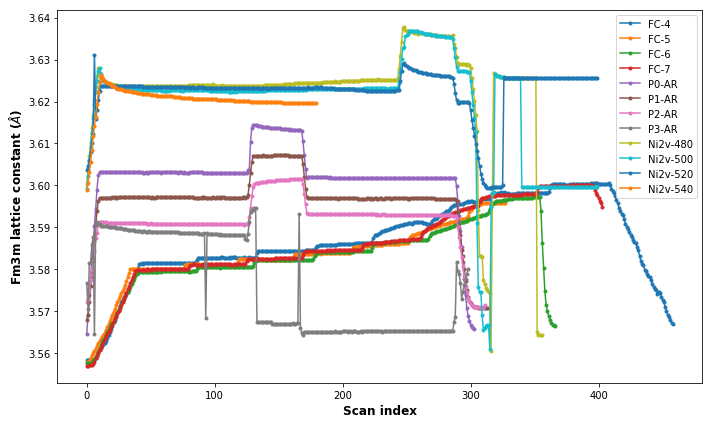

In [42]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot('111')

for i in big_picture:
    ax.plot(i[1],'-o',ms=3,label=i[0])
ax.legend(fontsize=10)

ax.set_xlabel(u'Scan index', fontsize=12, weight='bold')
ax.set_ylabel(u'Fm3m lattice constant ($\AA$)', fontsize=12, weight='bold') 

plt.tight_layout()

plt.savefig('big_picture2.pdf')